# NIH Project EDA

## Import Packages

In [1]:
import requests, re
import numpy as np
from lxml import etree
import xml.etree.ElementTree as ET
from tqdm import tqdm_notebook as tqdm
import zipfile, urllib
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy import stats
import collections
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

## Data Functions

In [2]:
def get_data_urls(year_range=None):
    """
        Args:
            year_range - List: Parameter will take either a 2 value list or `None`. If parameter is a list, results will be restricted to years less than the first value and greater than the second.
                Example: [2003, 2010] - Files returned : 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010
                Example: [2003, 2003] - Files returned : 2003
        Returns:
            all_data_links - List: List of links filtered by the requested `year_range`
    """
    url_base = 'https://exporter.nih.gov'
    url_search = url_base + '/ExPORTER_Catalog.aspx'

    url_text = requests.get(url_search).text

    parser = etree.XMLParser(recover=True)
    root = ET.fromstring(url_text, parser=parser)
    
    #### I stole this code from the internet but it will replace the prefix that gets added
    #### There's probably a better way to do this
    for elem in root.getiterator():
        if not hasattr(elem.tag, 'find'): continue
        i = elem.tag.find('}')
        if i >= 0:
            elem.tag = elem.tag[i+1:]
    ####
    data_2019 = [i.get('href') for i in root.findall('.//tr[@class="row_bg"]/td//a')]
    data_2019 = [i for i in data_2019  if ('XMLData' in i) and ('2019' in i)]
    data_2019 = [url_base + '/' + i for i in data_2019]
    
    
    ### Range + 1900 goes from 1985 to 2018    
    years = [1900 + i for i in range(85,119)]
    years = sorted(years, reverse = True)
    fy_links = [f'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY{year}.zip' for year in years]

    all_data_links = data_2019 + fy_links
    ### Make a copy because we modifying in place ya'll
    all_data_loop = all_data_links.copy()
    if year_range is not None:
        for link in all_data_loop:
            link_year = re.search('FY.{4}.*\.zip', link).group()
            ### Remove '.zip' then remove any '_\d' stuff that 2019 files have
            link_year = link_year.split('.')[0].split('_')[0]
            ### Remove 'FY'
            link_year = link_year[2:]
            link_year = int(link_year)
            if (link_year < year_range[0]) or (link_year > year_range[1]):
                ### modifying in place ya'll
                all_data_links.remove(link)
                
    return all_data_links

In [3]:
def extract_xml_from_zip(zip_links, out_format = 'dict'):
    """
    Function takes in a link to a zip file with an XML inside and will return a data structure containing that data.
    Data structure can be either a dictionary or a dataframe.
    
    """
    if isinstance(zip_links, str):
        zip_links = [zip_links]
    projects_dict = {}
    for zip_link in tqdm(zip_links, total=len(zip_links)):
        zip_file = zip_link.split('/')[-1]
        file_name = zip_file.split('.')[0]
        xml_name = file_name + '.xml'
        with zipfile.ZipFile(urllib.request.urlretrieve(zip_link, filename=None)[0], 'r') as archive:
            xml_data = archive.read(xml_name)
        rows = []
        root = ET.fromstring(xml_data)

        
        for project in root.findall('./row'):
            project_dict = {}
            for column in project.findall('./'):
                column_header = column.tag.lower()
                if column_header == 'project_termsx':
                    column_header = 'project_terms'
                if column_header == 'project_terms':
                    project_dict['project_terms'] = [i.text for i in column.findall('./')]
                else:
                    project_dict[column_header] = column.text
                
            project_dict['data_source'] = zip_link
            projects_dict[project_dict['application_id']] = project_dict
    
    if out_format.lower() == 'df':
        projects_dict = pd.DataFrame.from_dict(projects_dict, orient='index')
    return projects_dict

## Getting Data

In [67]:
urls = get_data_urls([2019,2019])
urls

['https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_053.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_052.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_051.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_050.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_049.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_048.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_047.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_046.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_045.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_044.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_043.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_042.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_PRJ_X_FY2019_041.zip',
 'https://exporter.nih.gov/XMLData/final/RePORTER_P

In [263]:
out_df = extract_xml_from_zip(urls[0], out_format = 'df')
print(out_df.shape)
out_df.head()


(822, 46)


,application_id,activity,administering_ic,application_type,arra_funded,award_notice_date,budget_start,budget_end,cfda_code,core_project_num,ed_inst_type,foa_number,full_project_num,funding_ics,funding_mechanism,fy,ic_name,nih_spending_cats,org_city,org_country,org_dept,org_district,org_duns,org_fips,org_ipf_code,org_name,org_state,org_zipcode,phr,pis,program_officer_name,project_start,project_end,project_terms,project_title,serial_number,study_section,study_section_name,subproject_id,support_year,suffix,direct_cost_amt,indirect_cost_amt,total_cost,total_cost_sub_project,data_source
10000664,10000664,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152640,None,RFA-OT-A1-007,1OT2HL152640-01,NHLBI:88401\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[Adult, Age, Biological Markers, Boston, Brain...",Boston Consortium to Cure SCD - Williams/Ellen...,152640,ZHL1,Special Emphasis Panel,None,01,None,88401,None,88401,None,https://exporter.nih.gov/XMLData/final/RePORTE...
10000666,10000666,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152639,None,RFA-OT-A1-007,1OT2HL152639-01,NHLBI:84000\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[acute chest syndrome, Affinity, Attenuated, b...",Boston Consortium to Cure SCD - Williams/John ...,152639,ZHL1,Special Emphasis Panel,None,01,None,84000,None,84000,None,https://exporter.nih.gov/XMLData/final/RePORTE...
10000883,10000883,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25392\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S1,15771,9621,None,25392,https://exporter.nih.gov/XMLData/final/RePORTE...
10000885,10000885,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PA-18-906,3P20CA202925-04S2,NCI:17237\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S2,11071,6166,None,17237,https://exporter.nih.gov/XMLData/final/RePORTE...
10000887,10000887,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25391\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,Project Narrative African Americans are diag...,None,"BAILEY, LEEANN ODETTE",None,None,"[5'-AMP-activated protein kinase, abiraterone,...",Pilot Project 1,202925,ZCA1,Special Emphasis Panel,7202,04,S1,15771,9620,None,25391,https://exporter.nih.gov/XMLData/final/RePORTE...


## Processing Data
### Length of Project

In [264]:
lop_list = []

for i, j in zip(out_df['project_start'], out_df['project_end']):
    
    try:
        date_diff = (dt.datetime.strptime(j, '%M/%d/%Y') - dt.datetime.strptime(i, '%M/%d/%Y')).days
        date_diff = date_diff / 365
    except TypeError:
        date_diff = ''
    
    lop_list.append(date_diff)

out_df['length_of_project'] = lop_list

,application_id,activity,administering_ic,application_type,arra_funded,award_notice_date,budget_start,budget_end,cfda_code,core_project_num,ed_inst_type,foa_number,full_project_num,funding_ics,funding_mechanism,fy,ic_name,nih_spending_cats,org_city,org_country,org_dept,org_district,org_duns,org_fips,org_ipf_code,org_name,org_state,org_zipcode,phr,pis,program_officer_name,project_start,project_end,project_terms,project_title,serial_number,study_section,study_section_name,subproject_id,support_year,suffix,direct_cost_amt,indirect_cost_amt,total_cost,total_cost_sub_project,data_source,length_of_project
10000664,10000664,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152640,None,RFA-OT-A1-007,1OT2HL152640-01,NHLBI:88401\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[Adult, Age, Biological Markers, Boston, Brain...",Boston Consortium to Cure SCD - Williams/Ellen...,152640,ZHL1,Special Emphasis Panel,None,01,None,88401,None,88401,None,https://exporter.nih.gov/XMLData/final/RePORTE...,0.989041
10000666,10000666,OT2,HL,1,N,09/24/2019,09/20/2019,02/17/2020,837,OT2HL152639,None,RFA-OT-A1-007,1OT2HL152639-01,NHLBI:84000\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[acute chest syndrome, Affinity, Attenuated, b...",Boston Consortium to Cure SCD - Williams/John ...,152639,ZHL1,Special Emphasis Panel,None,01,None,84000,None,84000,None,https://exporter.nih.gov/XMLData/final/RePORTE...,0.989041
10000883,10000883,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25392\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S1,15771,9621,None,25392,https://exporter.nih.gov/XMLData/final/RePORTE...,
10000885,10000885,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PA-18-906,3P20CA202925-04S2,NCI:17237\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S2,11071,6166,None,17237,https://exporter.nih.gov/XMLData/final/RePORTE...,
10000887,10000887,P20,CA,3,N,09/25/2019,09/01/2019,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25391\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,Project Narrative African Americans are diag...,None,"BAILEY, LEEANN ODETTE",None,None,"[5'-AMP-activated protein kinase, abiraterone,...",Pilot Project 1,202925,ZCA1,Special Emphasis Panel,7202,04,S1,15771,9620,None,25391,https://exporter.nih.gov/XMLData/final/RePORTE...,


### Project Start Buckets
Filter anyone missing a `budget_start` value then create yearly and quarterly buckets for project start.

In [267]:
print(f'out_df shape pre-`budget_start` filtering : {out_df.shape}')
base_df = out_df[[True if (i is not None) else False for i in out_df['budget_start']]]
print(f'base_df shape post-`budget_start` filtering : {base_df.shape}')
base_df.loc[:,'budget_start'] = [dt.datetime.strptime(i, '%m/%d/%Y') for i in base_df.loc[:,'budget_start']]

base_df.loc[:,'budget_start_year'] = [str(i.year) for i in base_df['budget_start']]
base_df.loc[:,'budget_start_yq'] = [f'{str(i.year)}_{str(pd.Timestamp(i).quarter)}' for i in base_df['budget_start']]

base_df.head()

out_df shape pre-`budget_start` filtering : (822, 47)
base_df shape post-`budget_start` filtering : (811, 47)


,application_id,activity,administering_ic,application_type,arra_funded,award_notice_date,budget_start,budget_end,cfda_code,core_project_num,ed_inst_type,foa_number,full_project_num,funding_ics,funding_mechanism,fy,ic_name,nih_spending_cats,org_city,org_country,org_dept,org_district,org_duns,org_fips,org_ipf_code,org_name,org_state,org_zipcode,phr,pis,program_officer_name,project_start,project_end,project_terms,project_title,serial_number,study_section,study_section_name,subproject_id,support_year,suffix,direct_cost_amt,indirect_cost_amt,total_cost,total_cost_sub_project,data_source,length_of_project,budget_start_year,budget_start_yq
10000664,10000664,OT2,HL,1,N,09/24/2019,2019-09-20,02/17/2020,837,OT2HL152640,None,RFA-OT-A1-007,1OT2HL152640-01,NHLBI:88401\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[Adult, Age, Biological Markers, Boston, Brain...",Boston Consortium to Cure SCD - Williams/Ellen...,152640,ZHL1,Special Emphasis Panel,None,01,None,88401,None,88401,None,https://exporter.nih.gov/XMLData/final/RePORTE...,0.989041,2019,2019_3
10000666,10000666,OT2,HL,1,N,09/24/2019,2019-09-20,02/17/2020,837,OT2HL152639,None,RFA-OT-A1-007,1OT2HL152639-01,NHLBI:84000\,OTHERS,2019,"NATIONAL HEART, LUNG, AND BLOOD INSTITUTE",None,BOSTON,UNITED STATES,None,07,076593722,US,1504801,BOSTON CHILDREN'S HOSPITAL,MA,021155724,None,None,"WELNIAK, LISBETH A",09/20/2019,02/17/2020,"[acute chest syndrome, Affinity, Attenuated, b...",Boston Consortium to Cure SCD - Williams/John ...,152639,ZHL1,Special Emphasis Panel,None,01,None,84000,None,84000,None,https://exporter.nih.gov/XMLData/final/RePORTE...,0.989041,2019,2019_3
10000883,10000883,P20,CA,3,N,09/25/2019,2019-09-01,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25392\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S1,15771,9621,None,25392,https://exporter.nih.gov/XMLData/final/RePORTE...,,2019,2019_3
10000885,10000885,P20,CA,3,N,09/25/2019,2019-09-01,08/31/2020,None,P20CA202925,None,PA-18-906,3P20CA202925-04S2,NCI:17237\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,This proposed NCI P20 collaborative partnershi...,None,"BAILEY, LEEANN ODETTE",None,None,"[Address, Advisory Committees, African America...",Admin Core,202925,ZCA1,Special Emphasis Panel,7201,04,S2,11071,6166,None,17237,https://exporter.nih.gov/XMLData/final/RePORTE...,,2019,2019_3
10000887,10000887,P20,CA,3,N,09/25/2019,2019-09-01,08/31/2020,None,P20CA202925,None,PAR-16-084,3P20CA202925-04S1,NCI:25391\,RESEARCH CENTERS,2019,NATIONAL CANCER INSTITUTE,None,DURHAM,UNITED STATES,None,01,044387793,US,2221101,DUKE UNIVERSITY,NC,277054673,Project Narrative African Americans are diag...,None,"BAILEY, LEEANN ODETTE",None,None,"[5'-AMP-activated protein kinase, abiraterone,...",Pilot Project 1,202925,ZCA1,Special Emphasis Panel,7202,04,S1,15771,9620,None,25391,https://exporter.nih.gov/XMLData/final/RePORTE...,,2019,2019_3


In [ ]:
sns.distplot()

## Project Length

### Distribution of project lengths

DescribeResult(nobs=612, minmax=(0.019178082191780823, 43.11232876712329), mean=4.4700510341122754, variance=18.105106439706244, skewness=4.408126531673315, kurtosis=27.982781098692513)


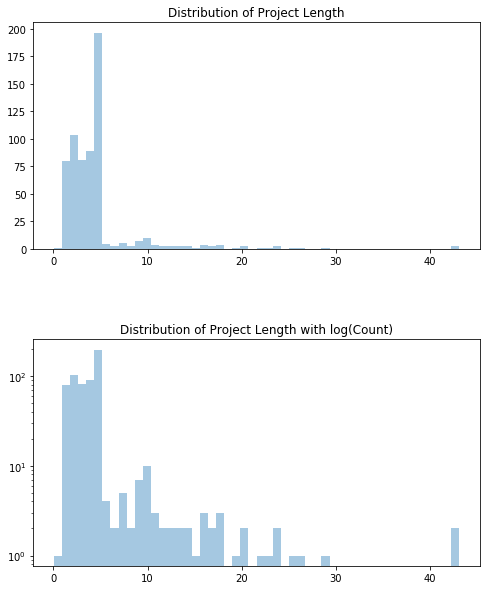

In [91]:
lop_df = base_df[[True if i != '' else False for i in example_df['length_of_project']]]
fig = plt.figure(figsize=(8,10))
lop_list = [i for i in lop_df['length_of_project']]

grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.6)
#plt.title('Publication Dates of all Microbiome Patents', pad=30, fontsize=24)
ax1 = fig.add_subplot(grid[0,:])
ax2 = fig.add_subplot(grid[1,:])

ax1.set_title('Distribution of Project Length')
ax2.set_title('Distribution of Project Length with log(Count)')

sns.distplot(lop_list, kde=False, ax=ax1)
sns.distplot(lop_list, kde=False, ax=ax2)
ax2.set_yscale('log')
print(stats.describe(lop_list))
plt.show()

### Longest projects

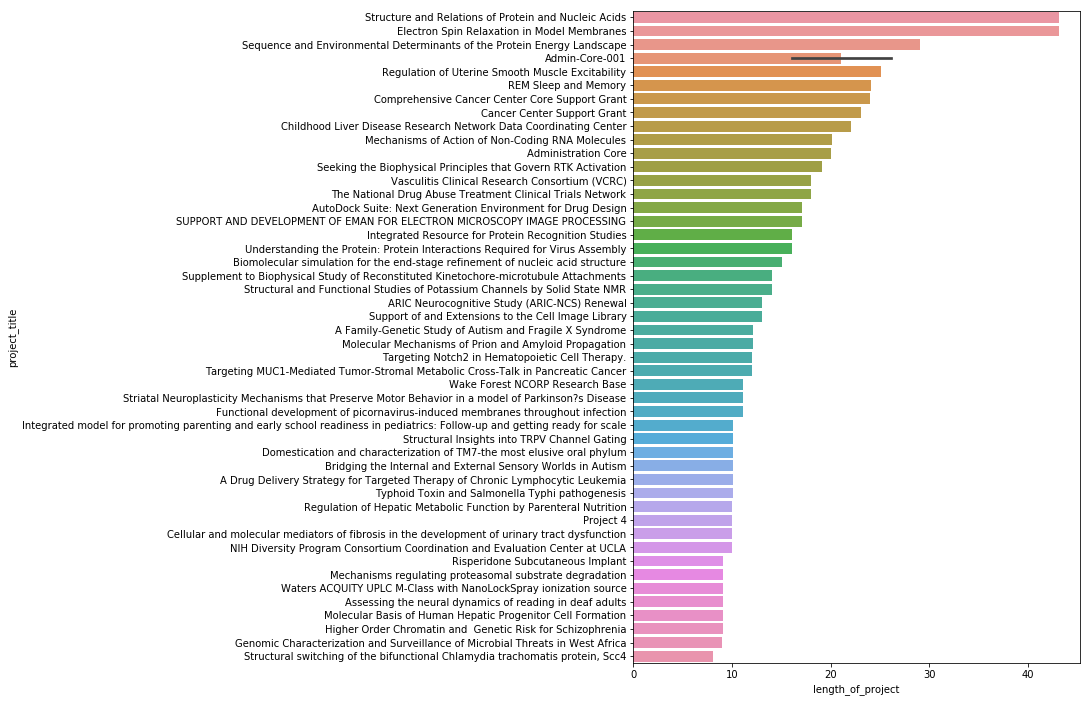

In [92]:
n = 50

trunc_lop_df = lop_df.sort_values('length_of_project', ascending=False).iloc[0:n,:]

fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_lop_df['length_of_project'], trunc_lop_df['project_title'])
plt.show()

### Mean project length by org distribution

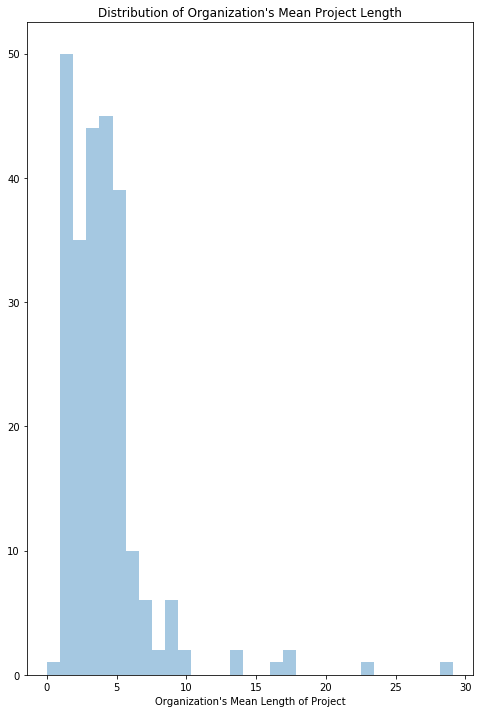

In [93]:
org_group_lop_df = lop_df[['org_name', 'length_of_project']].groupby('org_name').agg(['sum', 'count'])
org_group_lop_df['mean'] = org_group_lop_df['length_of_project']['sum'] / org_group_lop_df['length_of_project']['count']

fig = plt.figure(figsize=(8,12))
sns.distplot(org_group_lop_df['mean'], kde=False)
plt.title('Distribution of Organization\'s Mean Project Length')
plt.xlabel('Organization\'s Mean Length of Project')
plt.show()

### Longest Average Project Length by organization

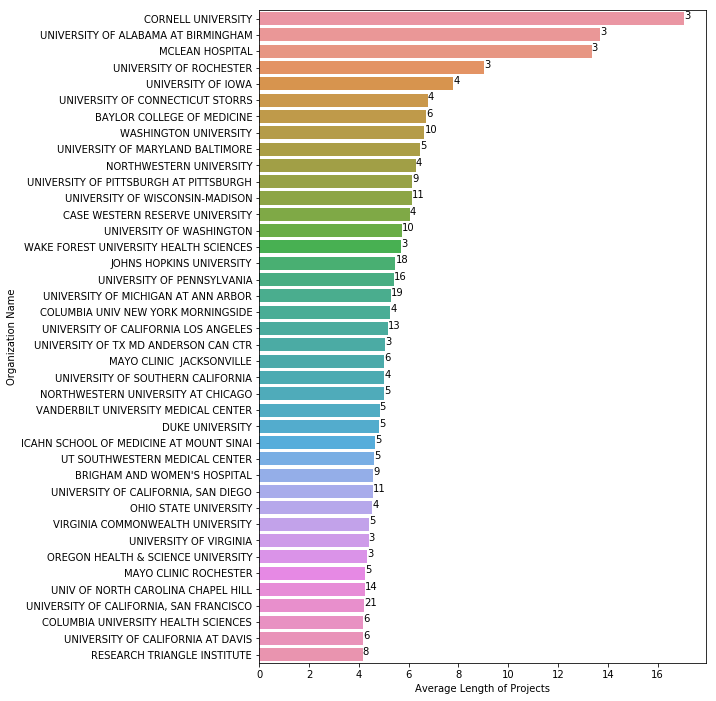

In [94]:
n = 40
min_count = 3
trunc_group_lop_df = org_group_lop_df[org_group_lop_df['length_of_project']['count'] >= min_count]
trunc_group_lop_df = trunc_group_lop_df.sort_values('mean', ascending=False).iloc[0:n, :]



fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_lop_df['mean'], trunc_group_lop_df.index)

for i, (c, m) in enumerate(zip(trunc_group_lop_df['length_of_project']['count'], trunc_group_lop_df['mean'])):
    plt.gca().text(m, i, str(c), fontsize=10)


plt.xlabel('Average Length of Projects')
plt.ylabel('Organization Name')
plt.show()


### Quickest Average Orgs

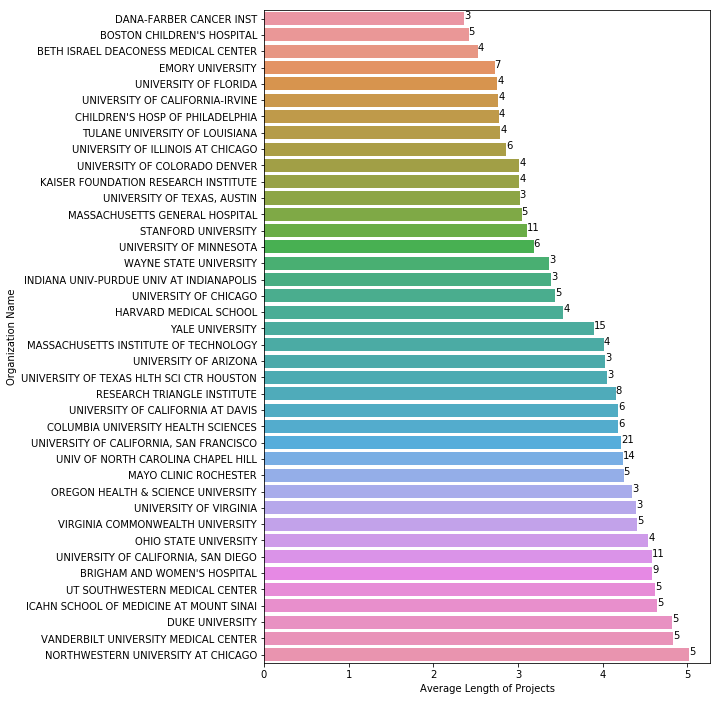

In [95]:
n = 40
min_count = 3
trunc_group_lop_df = org_group_lop_df[org_group_lop_df['length_of_project']['count'] >= min_count]
trunc_group_lop_df = trunc_group_lop_df.sort_values('mean', ascending=True).iloc[0:n, :]


fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_lop_df['mean'], trunc_group_lop_df.index)
for i, (c, m) in enumerate(zip(trunc_group_lop_df['length_of_project']['count'], trunc_group_lop_df['mean'])):
    plt.gca().text(m, i, str(c), fontsize=10)
plt.xlabel('Average Length of Projects')
plt.ylabel('Organization Name')
plt.show()


### Top average institutes

(27, 3)


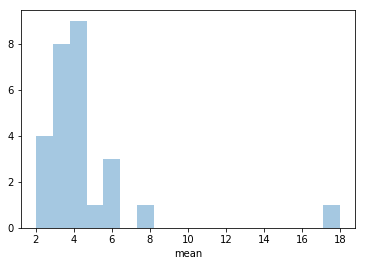

In [96]:
ic_group_lop_df = lop_df[['ic_name', 'length_of_project']].groupby('ic_name').agg(['sum', 'count'])
ic_group_lop_df['mean'] = ic_group_lop_df['length_of_project']['sum'] / ic_group_lop_df['length_of_project']['count']
print(ic_group_lop_df.shape)
sns.distplot(ic_group_lop_df['mean'], kde=False)

### Top institutes on average

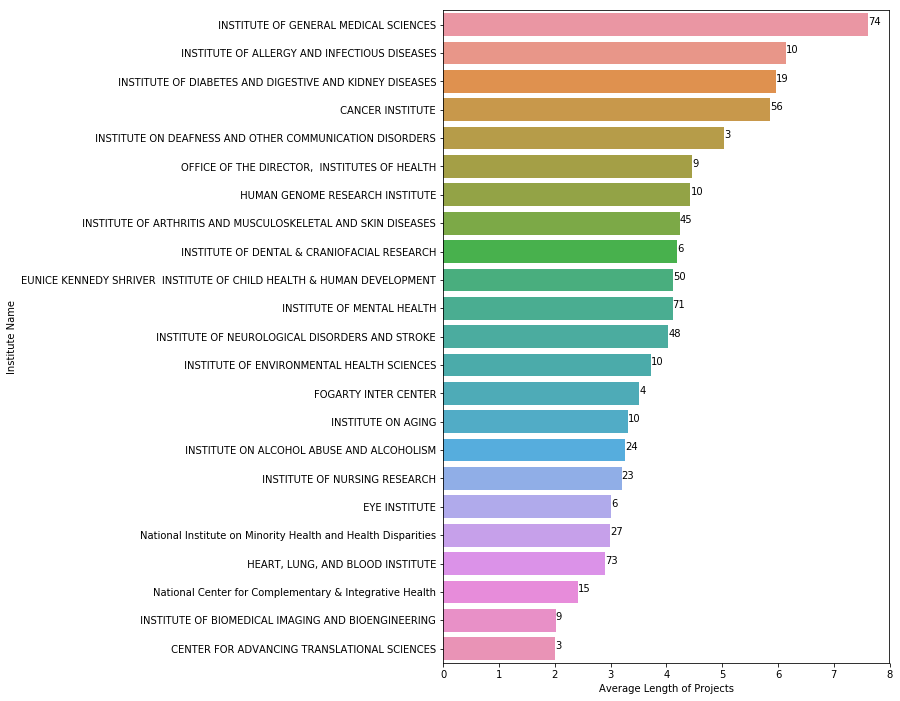

In [97]:
n = 40
min_count = 3
trunc_group_ic_lop_df = ic_group_lop_df[ic_group_lop_df['length_of_project']['count'] >= min_count]
trunc_group_ic_lop_df = trunc_group_ic_lop_df.sort_values('mean', ascending=False).iloc[0:n, :]
trunc_group_ic_lop_df.index = [i.replace('NATIONAL', '') for i in trunc_group_ic_lop_df.index]

fig = plt.figure(figsize=(8,12))
sns.barplot(trunc_group_ic_lop_df['mean'], trunc_group_ic_lop_df.index)
for i, (c, m) in enumerate(zip(trunc_group_ic_lop_df['length_of_project']['count'], trunc_group_ic_lop_df['mean'])):
    plt.gca().text(m, i, str(c), fontsize=10)
plt.xlabel('Average Length of Projects')
plt.ylabel('Institute Name')
plt.show()


## Org_name

In [98]:
organizations_df = base_df.dropna(axis=0,subset=['org_name'])
uni_pattern = '(UNIVERSITY)|(COLLEGE)|(SCHOOL)|( ?UNIV )|( COL ?)|( SCH ?)'
uni_organizations = [i for i in organizations_df['org_name'] if re.search(uni_pattern, i)]
n_data_rows = len(organizations_df['org_name'])
n_uni_rows = len(uni_organizations)
pct_uni = round(len(uni_organizations) / len(organizations_df['org_name']), 4)
print(f'Number of rows in data : {n_data_rows}\nNumber of College/Universities : {n_uni_rows} ({pct_uni}%)')

Number of rows in data : 822
Number of College/Universities : 612 (0.7445%)


### Colleges

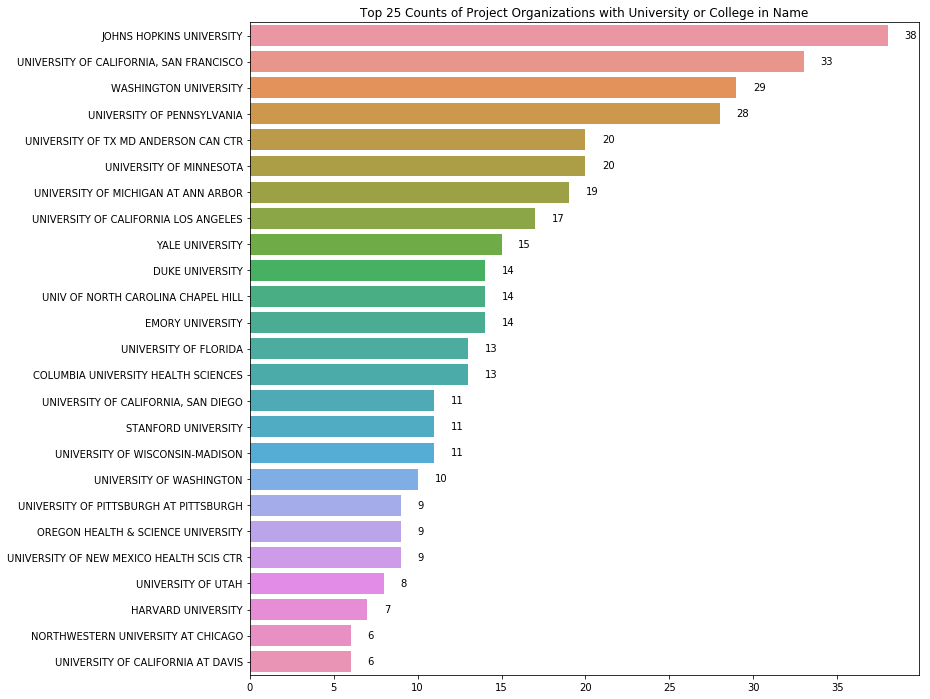

In [99]:
uni_df = organizations_df[[True if re.search(uni_pattern, i) else False for i in organizations_df['org_name']]]

n = 25

uni_counts_dict = collections.Counter(uni_df['org_name'])

top_count_unis = sorted(uni_counts_dict, key=uni_counts_dict.get, reverse=True)[:n]
top_unis_count = [uni_counts_dict[i] for i in top_count_unis]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_unis_count, top_count_unis)

for i, v in enumerate(top_unis_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Counts of Project Organizations with University or College in Name')
plt.show()

### Top Companies

In [100]:
company_df = organizations_df[[False if re.search(uni_pattern, i) else True for i in organizations_df['org_name']]]

print(f'There are {company_df.shape[0]} projects from non-academic organizations.')

There are 210 projects from non-academic organizations.


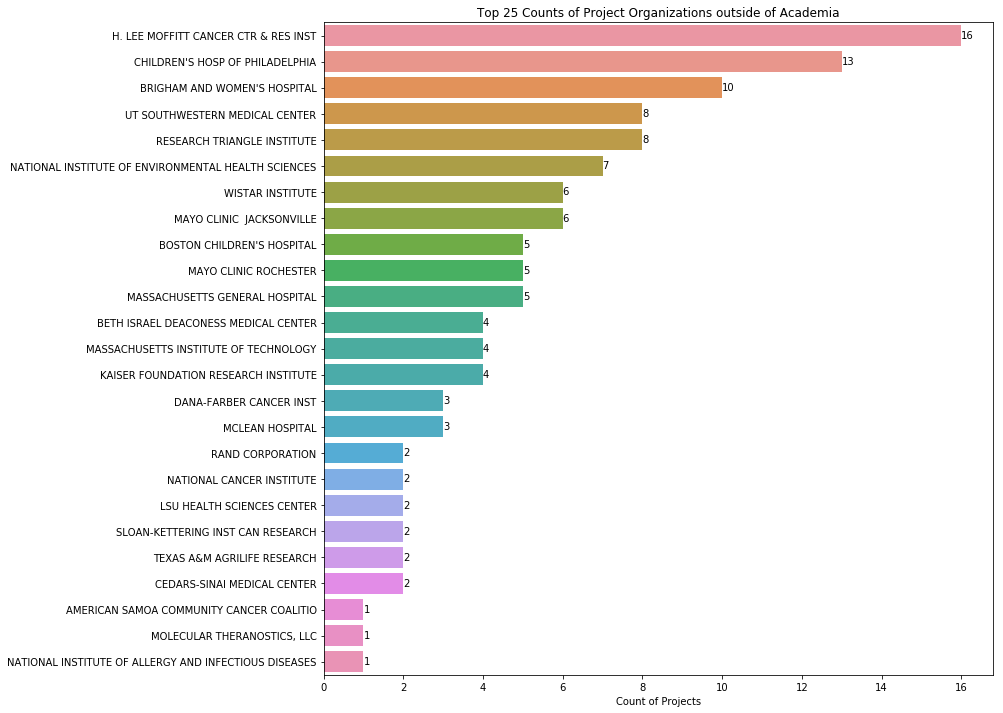

In [162]:
n = 25

comp_counts_dict = collections.Counter(company_df['org_name'])

top_count_comp = sorted(comp_counts_dict, key=comp_counts_dict.get, reverse=True)[:n]
top_comp_count = [comp_counts_dict[i] for i in top_count_comp]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_comp_count, top_count_comp)

for i, v in enumerate(top_comp_count):
    plt.gca().text(v, i+.1, str(v), fontsize=10)
plt.xlabel('Count of Projects')
plt.title(f'Top {n} Counts of Project Organizations outside of Academia')
plt.show()

## ic_name

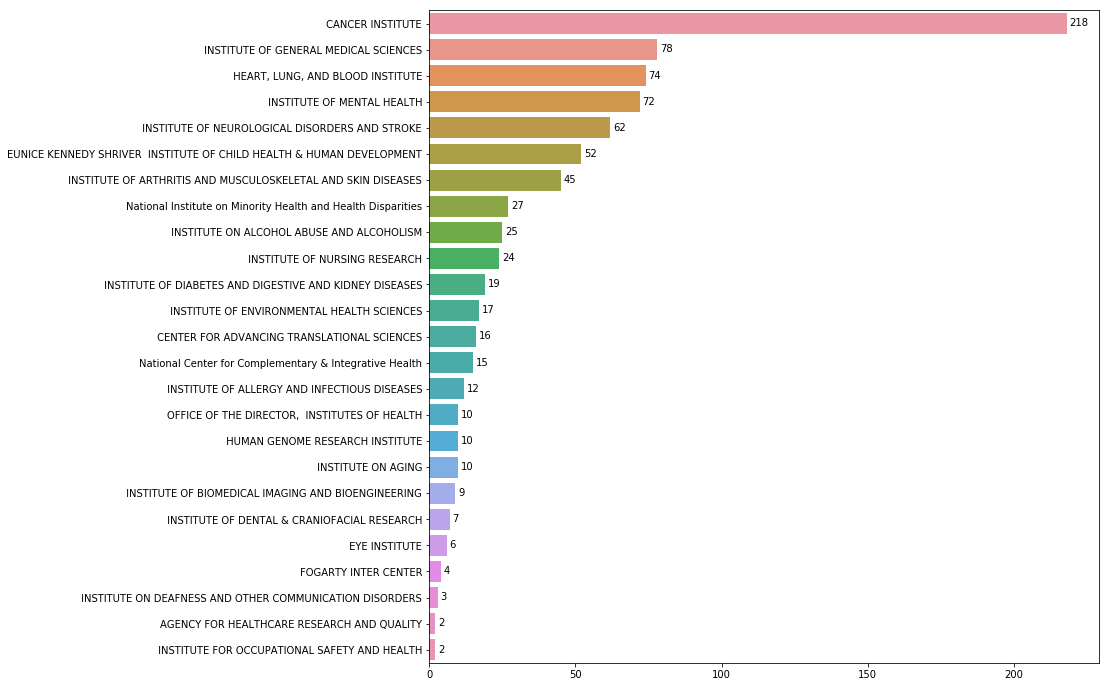

In [102]:
instit_df = base_df.dropna(axis=0,subset=['ic_name'])

n = 25

ic_name_counts_dict = collections.Counter(instit_df['ic_name'])

top_count_ic_name = sorted(ic_name_counts_dict, key=ic_name_counts_dict.get, reverse=True)[:n]
top_ic_name_count = [ic_name_counts_dict[i] for i in top_count_ic_name]

fig = plt.figure(figsize=(12,12))

top_count_ic_name = [i.replace('NATIONAL', '') for i in top_count_ic_name]

sns.barplot(top_ic_name_count, top_count_ic_name)

for i, v in enumerate(top_ic_name_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)

plt.show()

## total_cost

### Feature importances

In [197]:
tc_df = base_df[[True if (i != '') and (i is not None) else False for i in example_df['total_cost']]]

tc_df.total_cost = tc_df.total_cost.astype(int)

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### total_cost correlation function

In [209]:
def calc_corr_plot(in_df, column_name, list_n = 25, plot_n = 25, min_count = 1):
    
    in_df = in_df[['total_cost', column_name]]
    
    in_df = in_df[in_df[column_name].notnull()]
    loop_df = in_df.copy()
    for column in [column_name]:
        print(f'{column} has {len(in_df[column].unique())} unique values.')
        dummies_df = pd.get_dummies(in_df[column], prefix=f'{column}', )
        loop_df = pd.concat([loop_df, dummies_df], axis=1, sort=False)
        
    print('\nShape of dummies df :', loop_df.shape, '\n')
    
    grouped_df = in_df.groupby(column_name).agg(['sum', 'count', 'std'])['total_cost']
    grouped_df['mean'] = round(grouped_df['sum'] / grouped_df['count'], 4)
    
    min_count = 3
    below_thres_cols = grouped_df[grouped_df['count'] < min_count].index
    below_thres_cols = [column_name + '_' + i for i in below_thres_cols]
    loop_corr_df = loop_df.corr()['total_cost']
    trunc_loop_corr_df = loop_corr_df.drop(below_thres_cols)
    print(f'Top {list_n} Correlated Values in the {column_name} column.')
    print(trunc_loop_corr_df.sort_values(ascending=False)[1:list_n])
    print(f'\nBottom {list_n} Correlated Values in the {column_name} column.')
    print(trunc_loop_corr_df.sort_values(ascending=True)[1:list_n])
    fig = plt.figure(figsize=(15,20))
    grid = plt.GridSpec(2, 2, hspace=0.4, wspace=0.6)
    #plt.title('Publication Dates of all Microbiome Patents', pad=30, fontsize=24)
    ax1 = fig.add_subplot(grid[0,:])
    ax2 = fig.add_subplot(grid[1,:])
    #ax3 = fig.add_subplot(grid[:,1])
    
    
    top_keys = trunc_loop_corr_df.sort_values(ascending=False)[1:plot_n].keys()
    top_corr_values = trunc_loop_corr_df.sort_values(ascending=False)[1:plot_n].values
    top_means = [grouped_df.loc[i.replace(column_name + '_', ''), 'mean'] for i in top_keys]
    top_stds = [grouped_df.loc[i.replace(column_name + '_', ''), 'std'] for i in top_keys]
    top_counts = [grouped_df.loc[i.replace(column_name + '_', ''), 'count'] for i in top_keys]
    
    for i, v in enumerate(top_corr_values):
        if v < 0.01 * ax2.get_xlim()[1]:
            v_loc = 0.01 * ax2.get_xlim()[1]
        else:
            v_loc = v
        ax1.text(v_loc, i, str(round(v, 4)), fontsize=10)
    for i, (m, s, c) in enumerate(zip(top_means, top_stds, top_counts)):
        ax2.text(m, i+.2, '{:,.2f}'.format(m) + ' ({:,.2E}, {})'.format(s, c), fontsize=10)
        
    sns.barplot(top_corr_values, top_keys, ax=ax1)
    sns.barplot(top_means, top_keys, ax=ax2)
    plt.suptitle(f'\nData grouped By - {column_name}', fontsize = 20, x=.25)
    ax1.set_title(f'Groups Most Highly Correlated with `total_cost`\nLabels - Pearson Correlation', pad=10)
    ax2.set_title(f'Groups with the Highest Average `total_cost`\nLabels - Mean (StDev, N)', pad=10)
    ax1.set_ylabel(f'Top {plot_n} Correlation Values From {column_name}', labelpad=20)
    ax2.set_ylabel(f'Top {plot_n} Mean Group Values From {column_name}', labelpad=20)
    ax1.set_xlabel('Correlation Value')
    ax2.set_xlabel('Mean Value (Standard Deviation)')
    ax1.set_xlim(ax1.get_xlim()[0], ax1.get_xlim()[1]*1.05)
    ax2.set_xlim(ax2.get_xlim()[0], ax2.get_xlim()[1]*1.3)
    ax1_y_min, ax1_y_max = ax1.get_ylim()
    ax1.vlines(0, ax1_y_min, ax1_y_max)
    ax2_y_min, ax2_y_max = ax2.get_ylim()
    ax2.vlines(0, ax2_y_min, ax2_y_max)

    
    sns.despine()
    plt.show()

#### org_dept

org_dept has 43 unique values.

Shape of dummies df : (401, 45) 

Top 15 Correlated Values in the org_dept column.
org_dept_BIOSTATISTICS & OTHER MATH SCI    0.325244
org_dept_PHYSICAL MEDICINE & REHAB         0.150317
org_dept_ANESTHESIOLOGY                    0.055523
org_dept_UROLOGY                           0.036491
org_dept_PEDIATRICS                        0.025894
org_dept_INTERNAL MEDICINE/MEDICINE        0.023542
org_dept_RADIATION-DIAGNOSTIC/ONCOLOGY     0.018782
org_dept_GENETICS                          0.017491
org_dept_DENTISTRY                         0.015326
org_dept_PUBLIC HEALTH & PREV MEDICINE     0.009916
org_dept_PATHOLOGY                         0.006698
org_dept_VETERINARY SCIENCES               0.003769
org_dept_ENGINEERING (ALL TYPES)           0.001524
org_dept_MISCELLANEOUS                    -0.000502
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_dept column.
org_dept_NEUROSCIENCES                 -0.046413
org_dept_NONE         

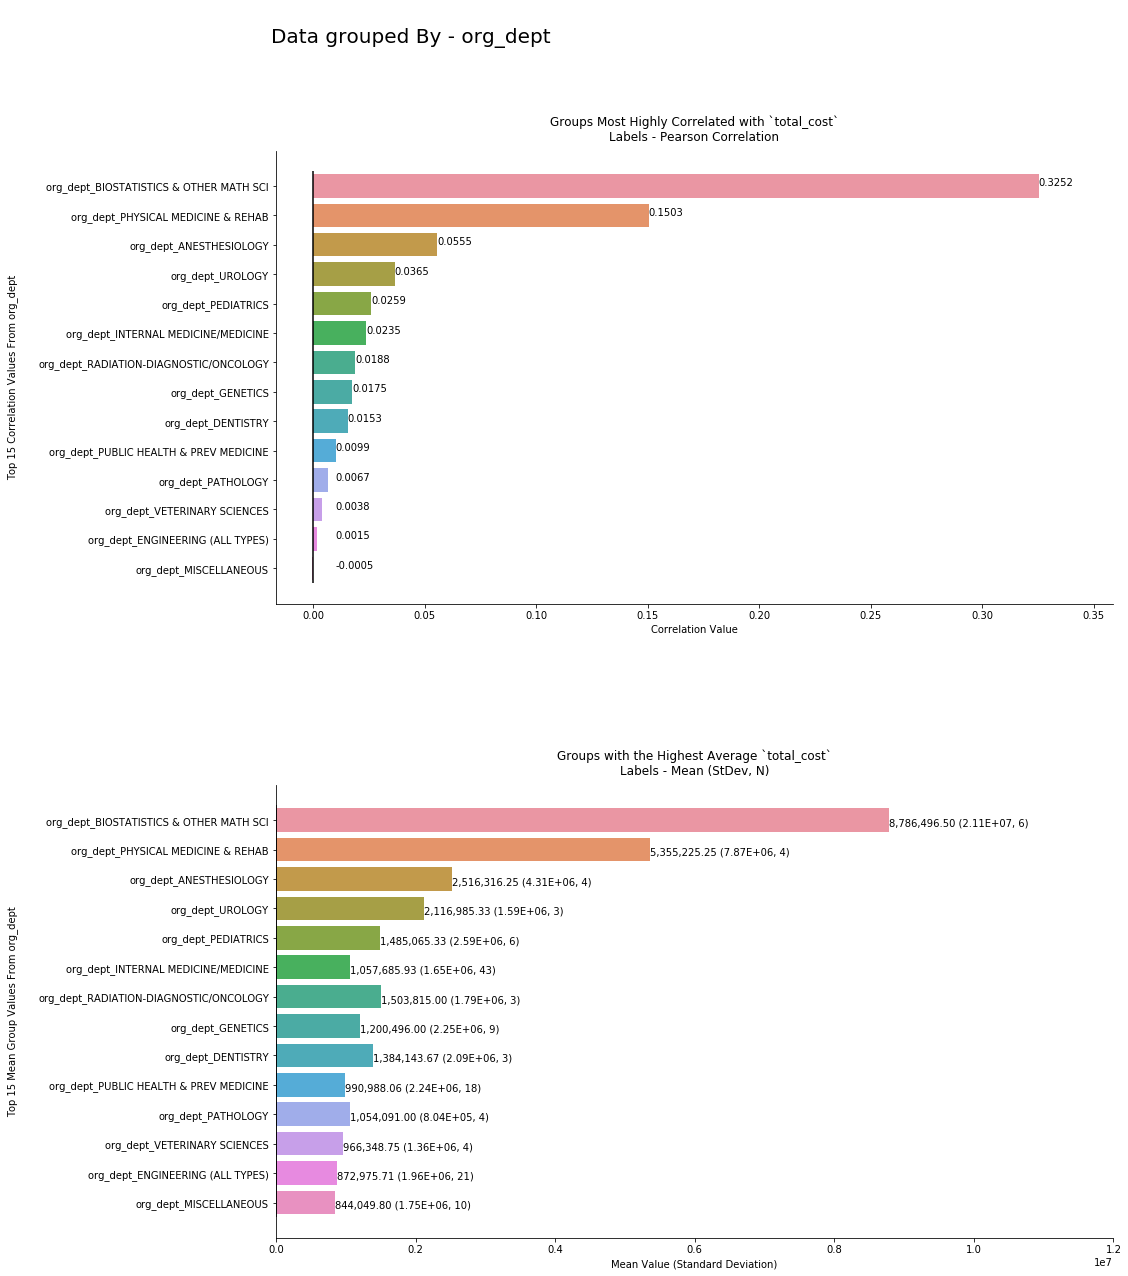

In [210]:
calc_corr_plot(tc_df, column_name='org_dept', list_n = 15, plot_n = 15, min_count = 3)

#### org_name

org_name has 248 unique values.

Shape of dummies df : (579, 250) 

Top 15 Correlated Values in the org_name column.
org_name_UNIV OF NORTH CAROLINA CHAPEL HILL         0.246660
org_name_DUKE UNIVERSITY                            0.071758
org_name_HARVARD UNIVERSITY                         0.064078
org_name_UNIVERSITY OF PITTSBURGH AT PITTSBURGH     0.057364
org_name_UNIVERSITY OF MICHIGAN AT ANN ARBOR        0.044786
org_name_MCLEAN HOSPITAL                            0.030516
org_name_UNIVERSITY OF PENNSYLVANIA                 0.028241
org_name_MASSACHUSETTS INSTITUTE OF TECHNOLOGY      0.025933
org_name_UT SOUTHWESTERN MEDICAL CENTER             0.021460
org_name_UNIVERSITY OF CALIFORNIA, SAN FRANCISCO    0.017329
org_name_OREGON HEALTH & SCIENCE UNIVERSITY         0.014390
org_name_JOHNS HOPKINS UNIVERSITY                   0.013010
org_name_UNIVERSITY OF WASHINGTON                   0.009979
org_name_KAISER FOUNDATION RESEARCH INSTITUTE       0.008532
Name: total_cost, dtype: floa

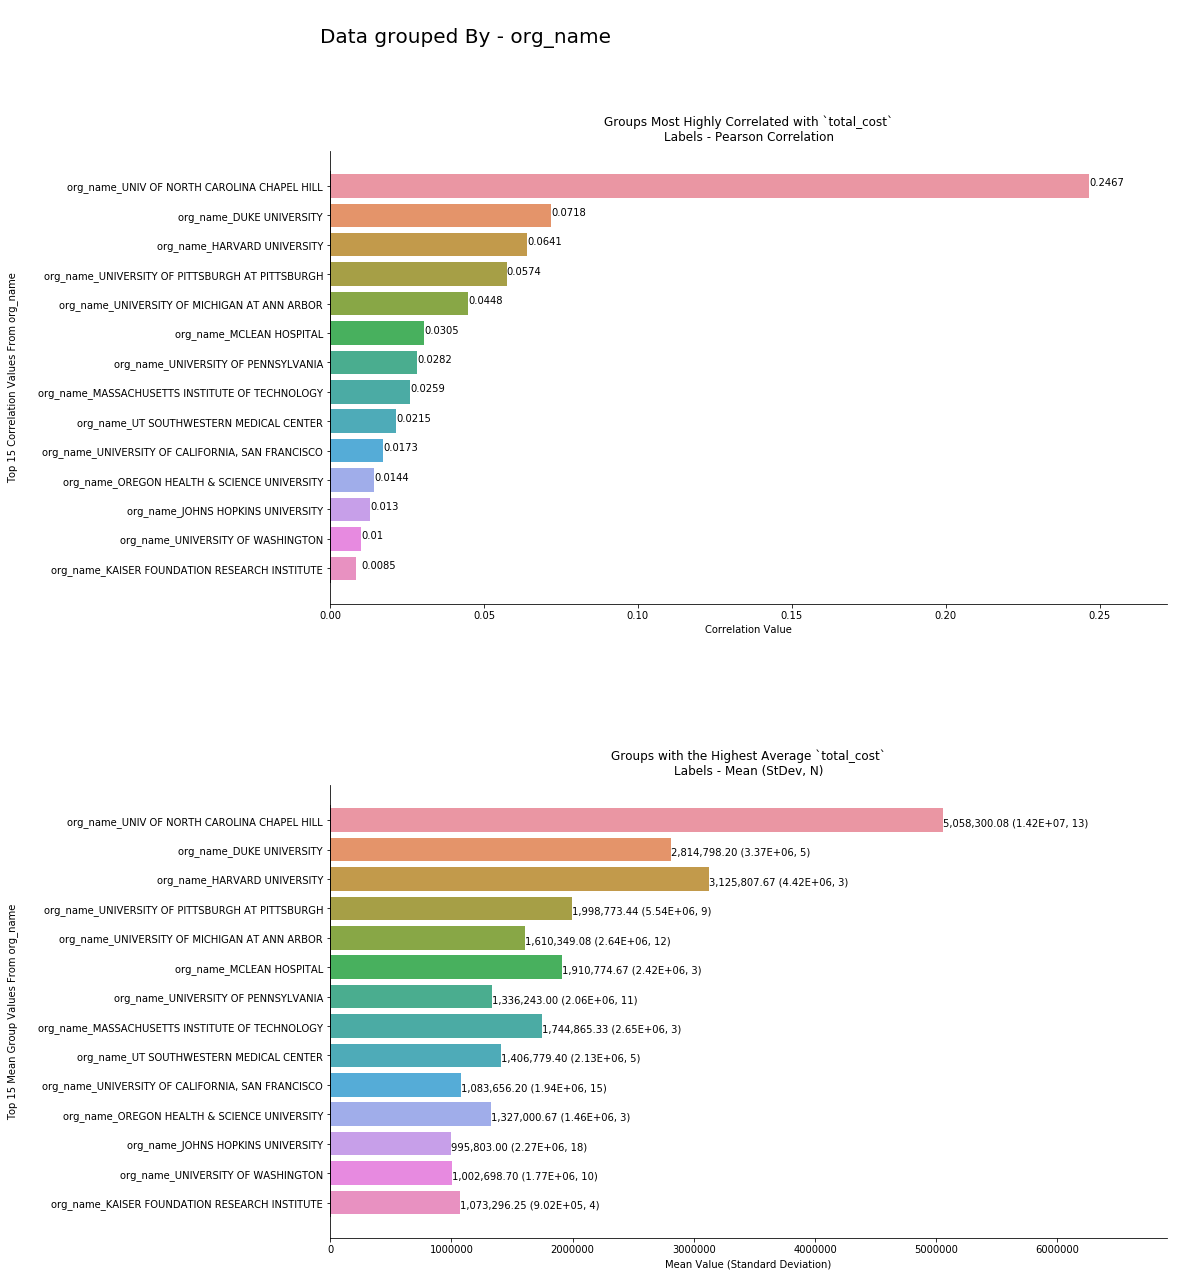

In [211]:
calc_corr_plot(tc_df, column_name= 'org_name', list_n = 15, plot_n = 15, min_count = 3)

#### org_state

org_state has 42 unique values.

Shape of dummies df : (562, 44) 

Top 15 Correlated Values in the org_state column.
org_state_NC    0.202912
org_state_AL    0.072279
org_state_PR    0.044422
org_state_PA    0.028574
org_state_MI    0.028495
org_state_WA    0.025232
org_state_MA    0.003946
org_state_MD   -0.002237
org_state_CT   -0.006210
org_state_NE   -0.007990
org_state_CA   -0.011322
org_state_DC   -0.011946
org_state_OR   -0.012381
org_state_RI   -0.013287
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_state column.
org_state_NY   -0.031166
org_state_GA   -0.029155
org_state_MN   -0.028316
org_state_IL   -0.028157
org_state_OH   -0.027067
org_state_IN   -0.025435
org_state_TX   -0.024089
org_state_KS   -0.024036
org_state_MO   -0.022377
org_state_NH   -0.022376
org_state_CO   -0.022215
org_state_AZ   -0.019183
org_state_TN   -0.018581
org_state_UT   -0.017152
Name: total_cost, dtype: float64


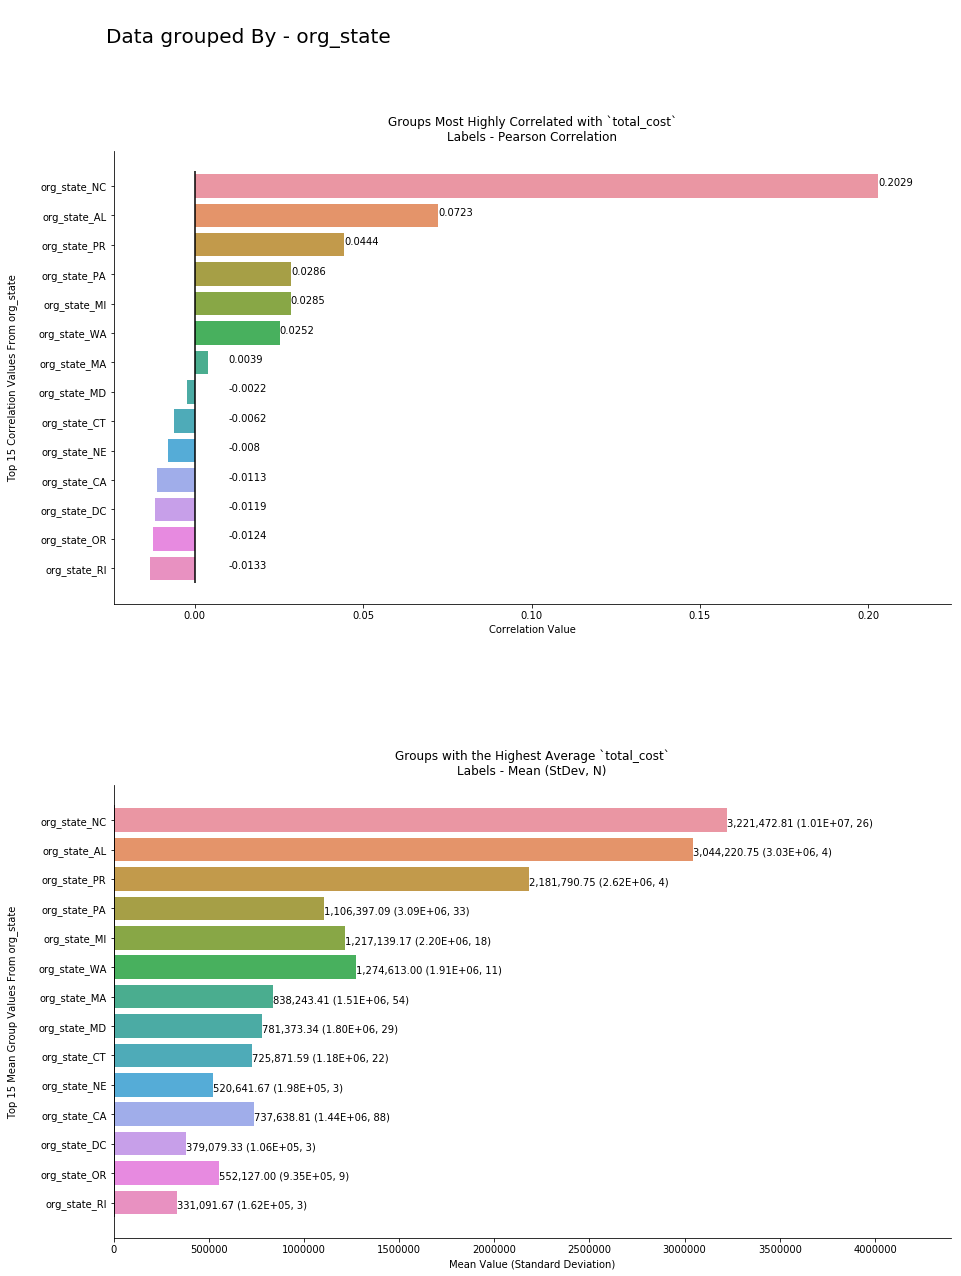

In [212]:
calc_corr_plot(tc_df, column_name='org_state', list_n = 15, plot_n = 15, min_count = 3)

#### org_country

org_country has 5 unique values.

Shape of dummies df : (568, 7) 

Top 15 Correlated Values in the org_country column.
org_country_UNITED STATES    0.024115
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_country column.
total_cost    1.0
Name: total_cost, dtype: float64


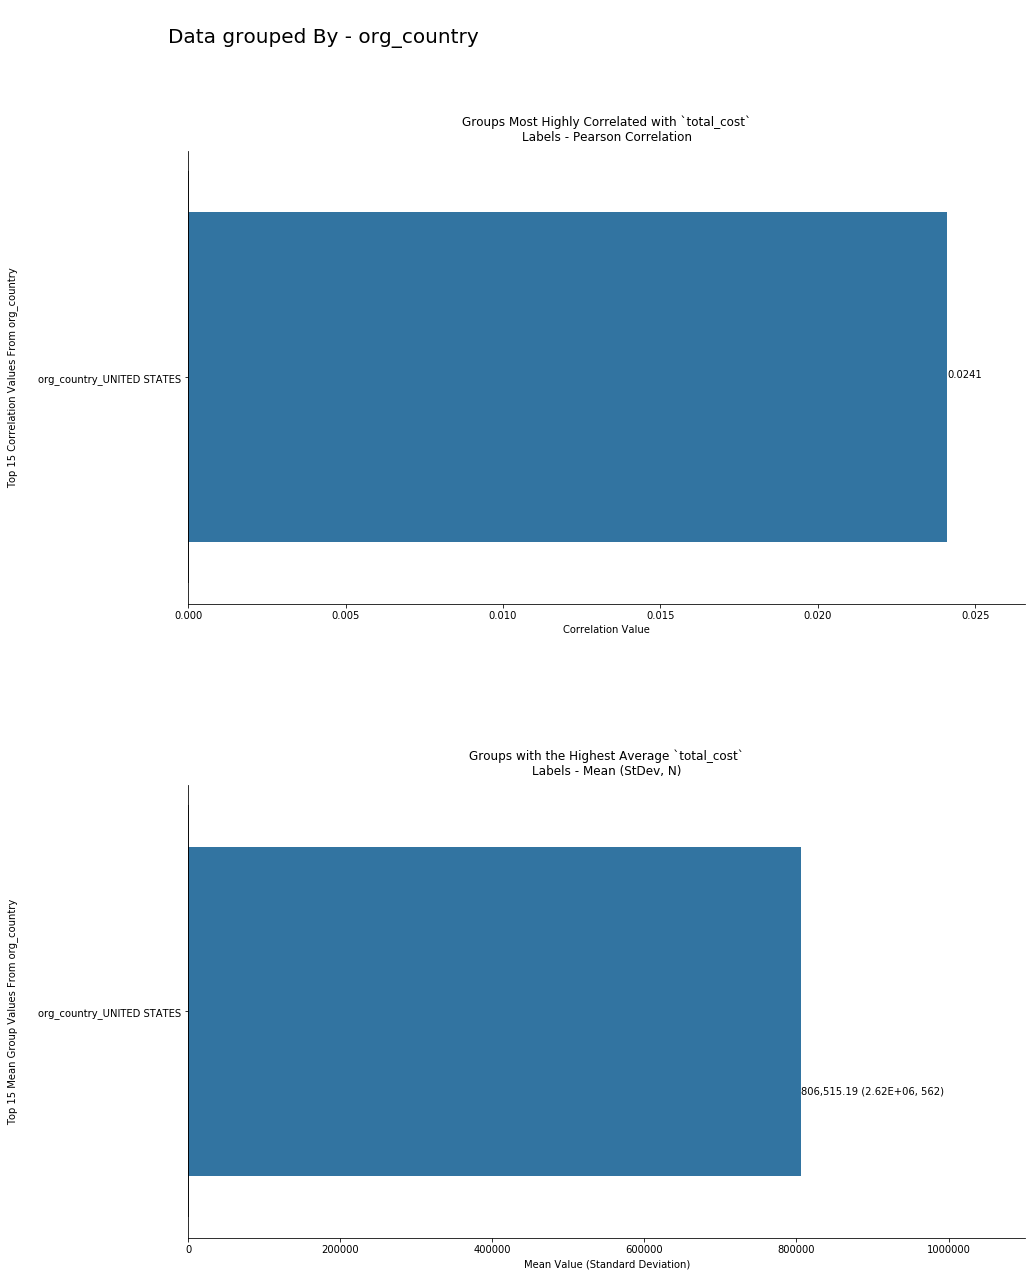

In [213]:
calc_corr_plot(tc_df, column_name='org_country', list_n = 15, plot_n = 15)

#### org_city

org_city has 162 unique values.

Shape of dummies df : (568, 164) 

Top 15 Correlated Values in the org_city column.
org_city_CHAPEL HILL      0.249872
org_city_DURHAM           0.062392
org_city_SAN JUAN         0.058587
org_city_PITTSBURGH       0.052416
org_city_ANN ARBOR        0.045643
org_city_CAMBRIDGE        0.044493
org_city_BELMONT          0.031032
org_city_SEATTLE          0.025571
org_city_DALLAS           0.021923
org_city_SAN FRANCISCO    0.017911
org_city_PORTLAND         0.014723
org_city_CORAL GABLES     0.011661
org_city_OAKLAND          0.008824
org_city_PHILADELPHIA     0.007683
Name: total_cost, dtype: float64

Bottom 15 Correlated Values in the org_city column.
org_city_ROCHESTER      -0.028258
org_city_Chicago        -0.025692
org_city_RICHMOND       -0.025409
org_city_ATLANTA        -0.023947
org_city_BOSTON         -0.023404
org_city_HOUSTON        -0.021910
org_city_GAINESVILLE    -0.020590
org_city_SAINT LOUIS    -0.020493
org_city_STANFORD       -0.020326
o

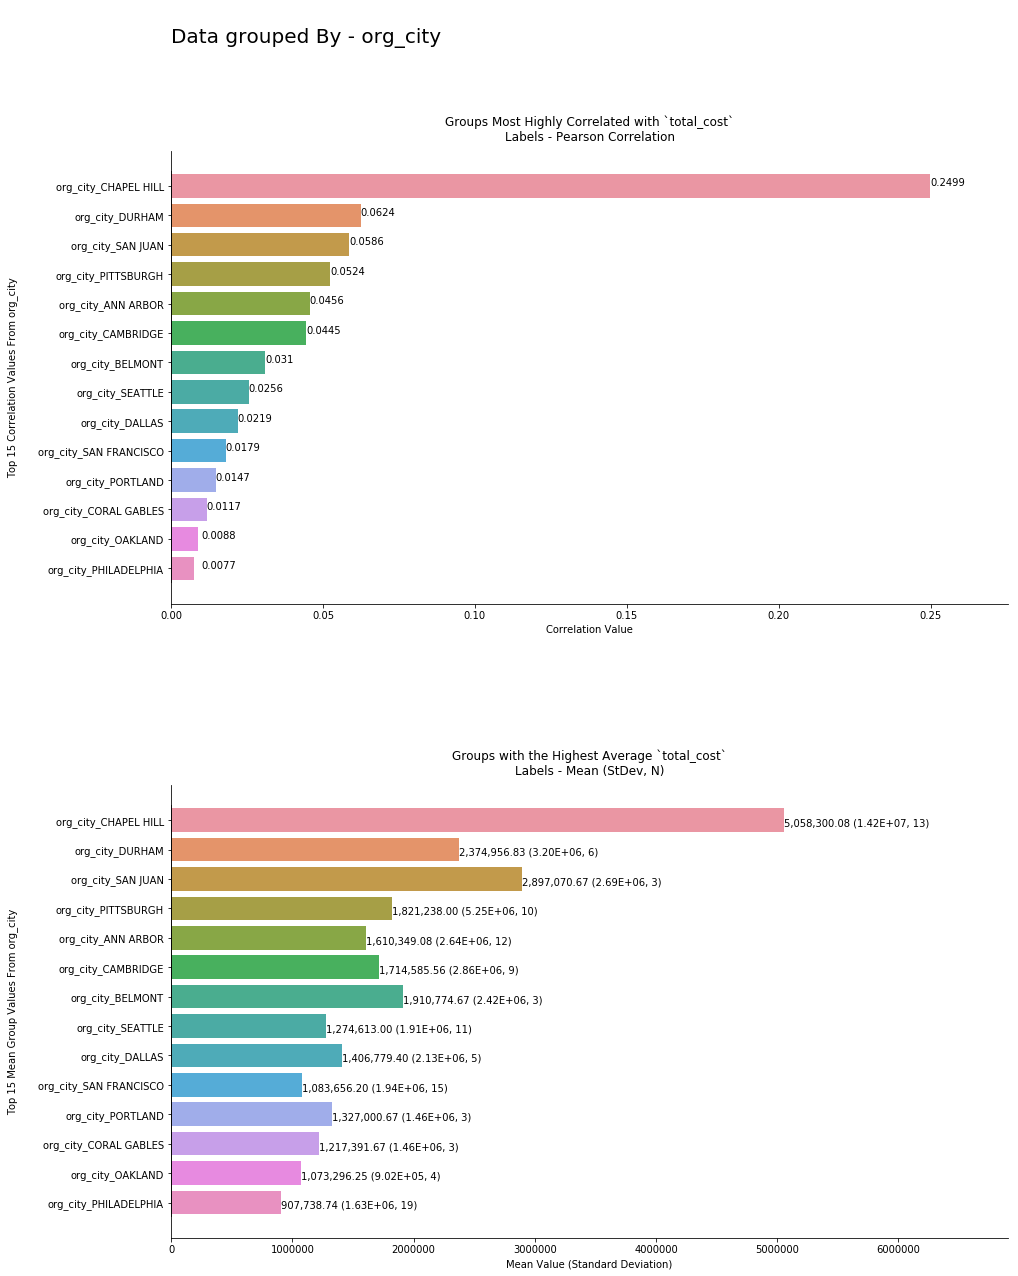

In [214]:
calc_corr_plot(tc_df, column_name='org_city', list_n = 15, plot_n = 15)

#### ic_name

ic_name has 26 unique values.

Shape of dummies df : (579, 28) 

Top 15 Correlated Values in the ic_name column.
ic_name_NATIONAL INSTITUTE OF ARTHRITIS AND MUSCULOSKELETAL AND SKIN DISEASES    0.197374
ic_name_OFFICE OF THE DIRECTOR, NATIONAL INSTITUTES OF HEALTH                    0.188433
ic_name_NATIONAL CANCER INSTITUTE                                                0.069654
ic_name_National Center for Complementary & Integrative Health                   0.032052
ic_name_NATIONAL INSTITUTE OF ALLERGY AND INFECTIOUS DISEASES                    0.027399
ic_name_NATIONAL INSTITUTE OF DENTAL & CRANIOFACIAL RESEARCH                     0.018526
ic_name_NATIONAL HEART, LUNG, AND BLOOD INSTITUTE                                0.018137
ic_name_NATIONAL CENTER FOR ADVANCING TRANSLATIONAL SCIENCES                     0.017369
ic_name_NATIONAL HUMAN GENOME RESEARCH INSTITUTE                                -0.000565
ic_name_NATIONAL INSTITUTE OF DIABETES AND DIGESTIVE AND KIDNEY DISEASES     

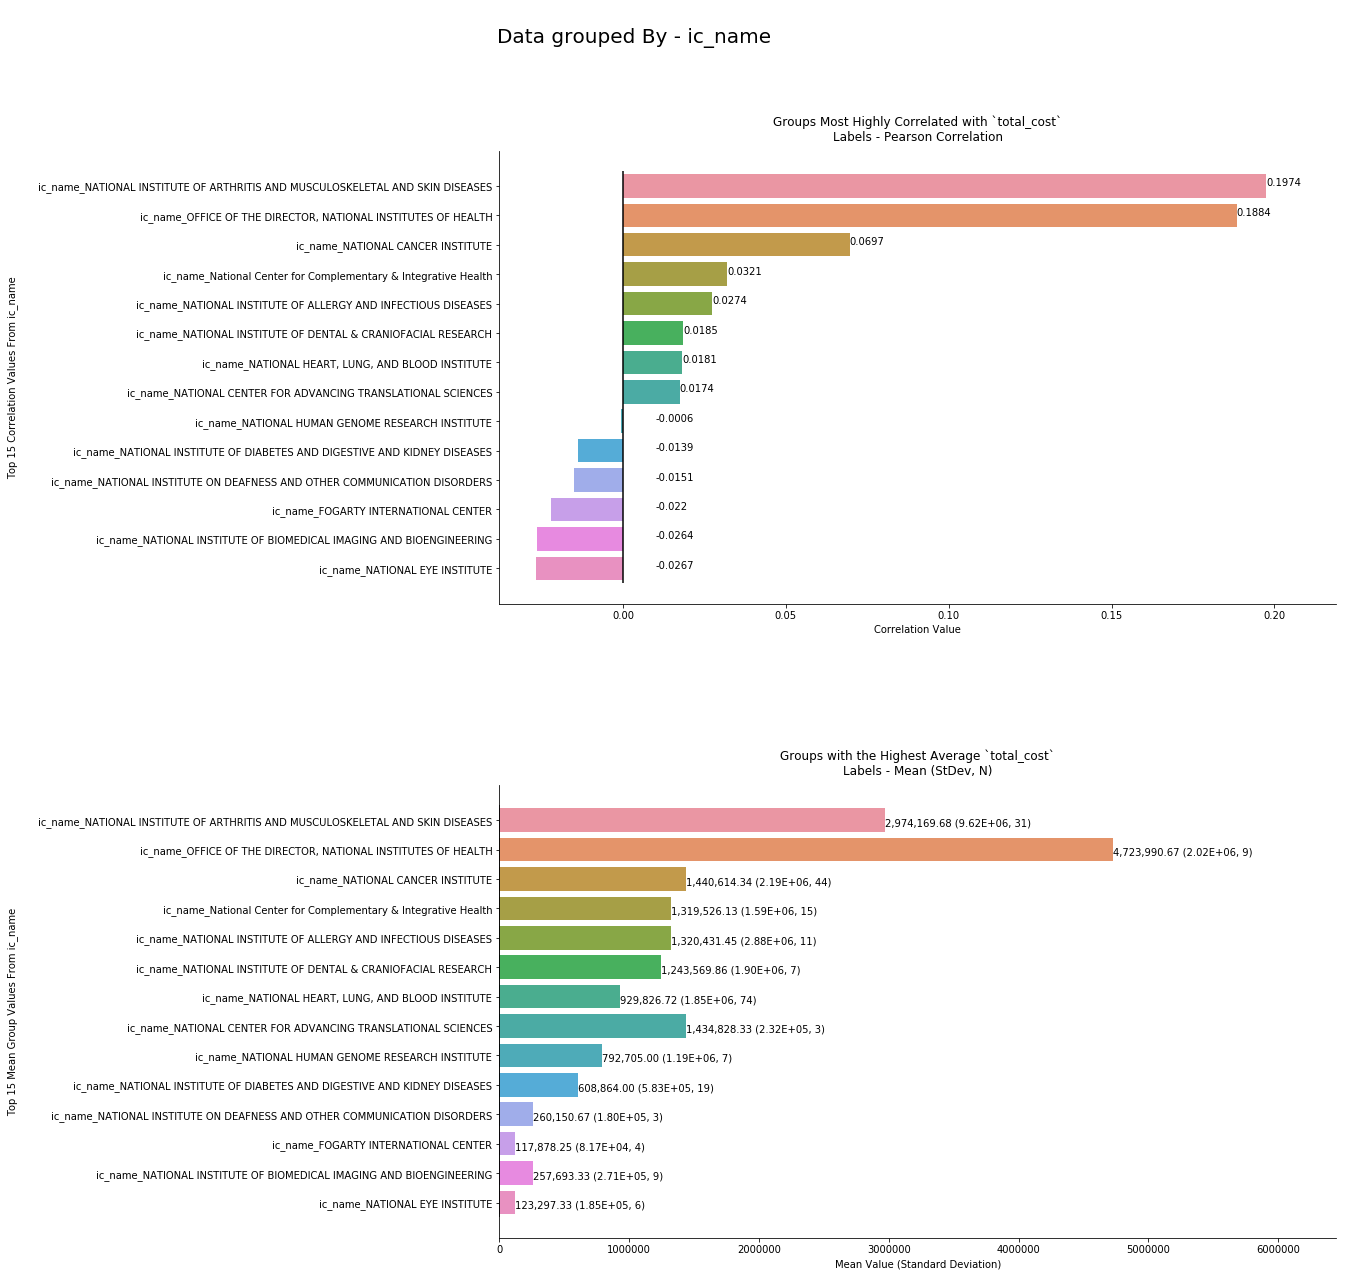

In [215]:
calc_corr_plot(tc_df, column_name='ic_name', list_n = 15, plot_n = 15)

## Text distribution

In [216]:
terms_df = base_df[[True if (i != '') and (i is not None) else False for i in example_df['project_terms']]]

print(terms_df.shape)

(822, 47)


In [225]:
terms_corpus = [','.join(i) for i in terms_df['project_terms']]
terms_corpus = [i.strip() for i in terms_corpus if i.strip() != '']
terms_corpus = ','.join(terms_corpus).lower()
terms_corpus = list(set(terms_corpus.split(',')))


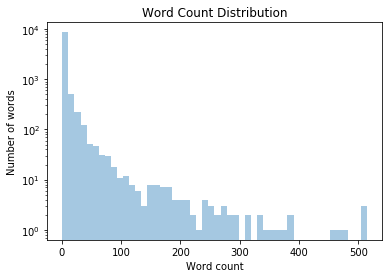

In [248]:
term_counts_dict = {}

for project_terms in terms_df['project_terms']:
    for term in project_terms:
        term = term.lower()
        if term in term_counts_dict.keys():
            term_counts_dict[term] += 1
        else:
            term_counts_dict[term] = 1
            
sns.distplot(list(term_counts_dict.values()), kde=False)
plt.yscale('log')
plt.title('Word Count Distribution')
plt.ylabel('Number of words')
plt.xlabel('Number of Appearences')

plt.show()

### Most Common Terms in All Projects

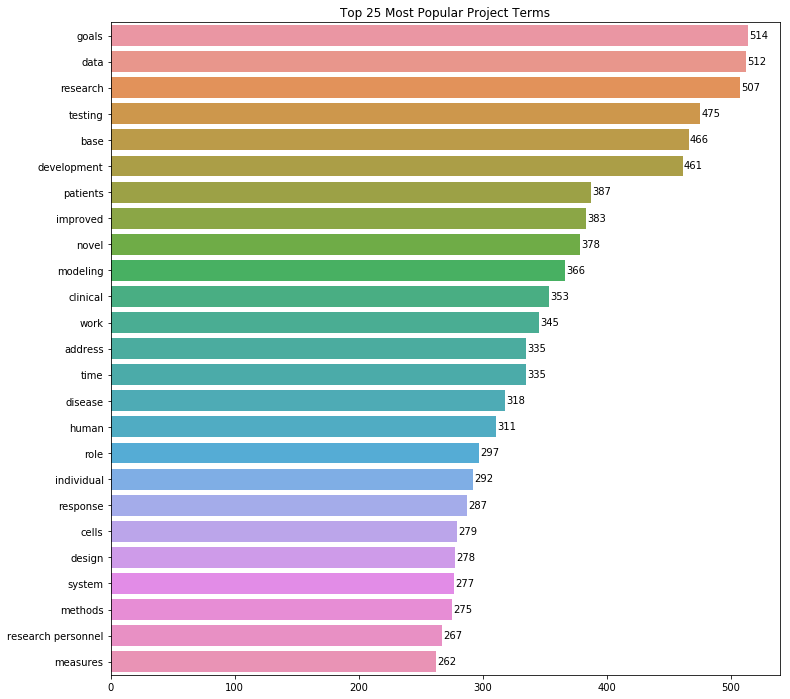

In [241]:
n = 25

top_count_terms = sorted(term_counts_dict, key=term_counts_dict.get, reverse=True)[:n]
top_terms_count = [term_counts_dict[i] for i in top_count_terms]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_terms_count, top_count_terms)

for i, v in enumerate(top_terms_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Most Popular Project Terms')
plt.show()

#### Most Common Terms in Academic Projects

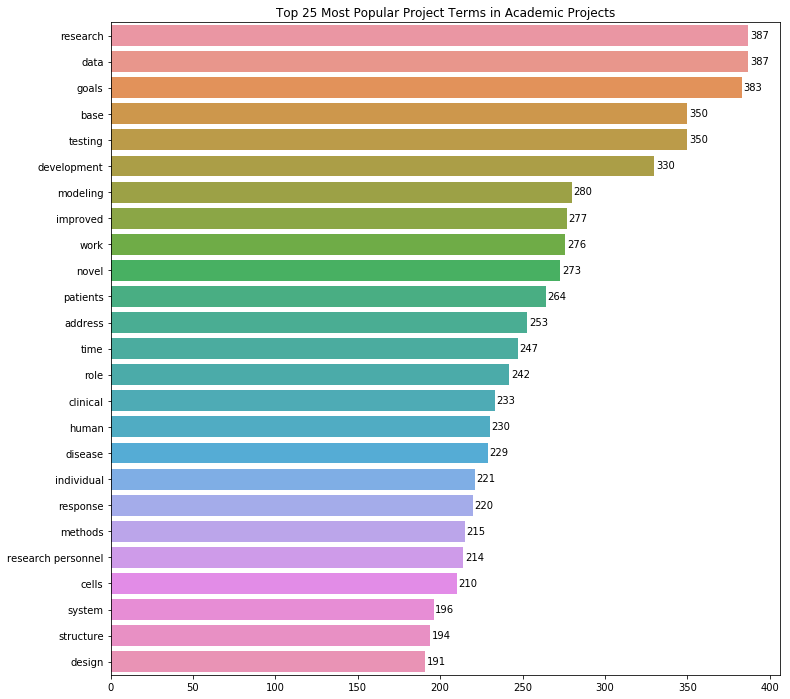

In [251]:
uni_terms_df = terms_df[[True if re.search(uni_pattern, i) else False for i in terms_df['org_name']]]

uni_terms_df.shape

n = 25

uni_term_counts_dict = {}

for project_terms in uni_terms_df['project_terms']:
    for term in project_terms:
        term = term.lower()
        if term in uni_term_counts_dict.keys():
            uni_term_counts_dict[term] += 1
        else:
            uni_term_counts_dict[term] = 1

top_count_uni_terms = sorted(uni_term_counts_dict, key=uni_term_counts_dict.get, reverse=True)[:n]
top_uni_terms_count = [uni_term_counts_dict[i] for i in top_count_uni_terms]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_uni_terms_count, top_count_uni_terms)

for i, v in enumerate(top_uni_terms_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Most Popular Project Terms in Academic Projects')
plt.show()

#### Most Common Terms in Industry Projects

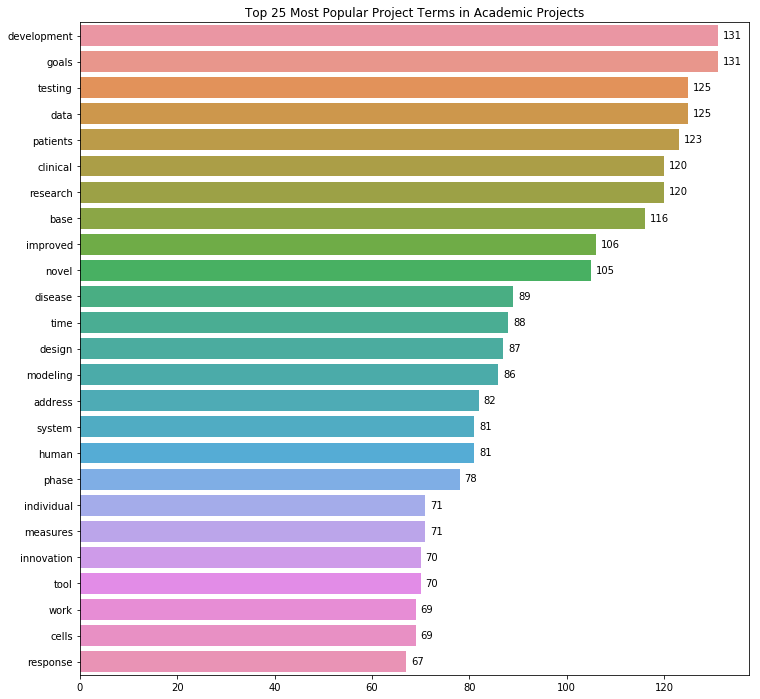

In [252]:
ind_terms_df = terms_df[[False if re.search(uni_pattern, i) else True for i in terms_df['org_name']]]

uni_terms_df.shape

n = 25

uni_term_counts_dict = {}

for project_terms in uni_terms_df['project_terms']:
    for term in project_terms:
        term = term.lower()
        if term in uni_term_counts_dict.keys():
            uni_term_counts_dict[term] += 1
        else:
            uni_term_counts_dict[term] = 1

top_count_uni_terms = sorted(uni_term_counts_dict, key=uni_term_counts_dict.get, reverse=True)[:n]
top_uni_terms_count = [uni_term_counts_dict[i] for i in top_count_uni_terms]

fig = plt.figure(figsize=(12,12))

sns.barplot(top_uni_terms_count, top_count_uni_terms)

for i, v in enumerate(top_uni_terms_count):
    plt.gca().text(v+1, i+.1, str(v), fontsize=10)
    
plt.title(f'Top {n} Most Popular Project Terms in Academic Projects')
plt.show()